### Laboratorio clase 5: Introducción y contexto

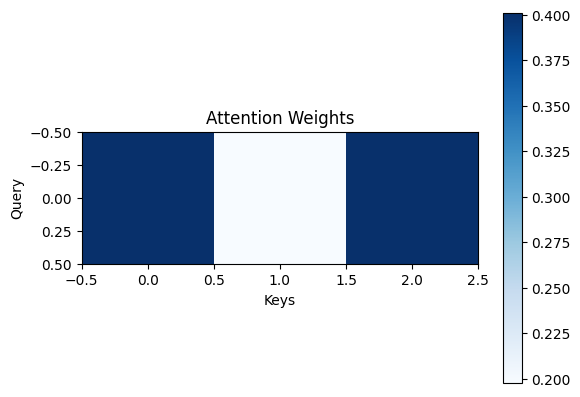

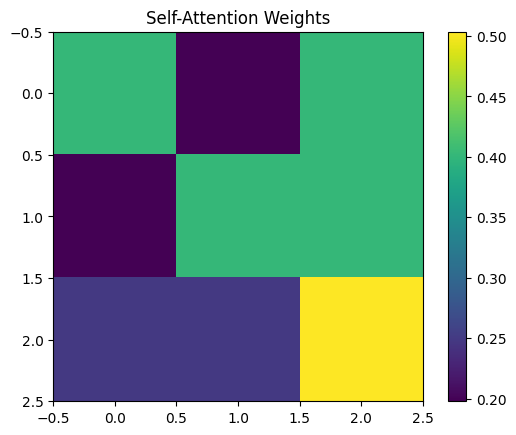

Context shape: torch.Size([1, 1, 16])


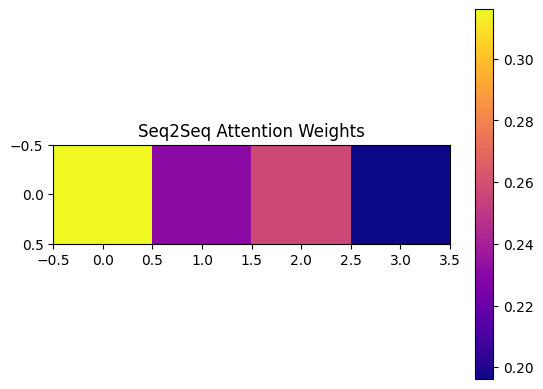

Paso 0, pérdida: 3.6191
Paso 50, pérdida: 0.5721
Paso 100, pérdida: 0.2934
Paso 150, pérdida: 0.2125
Paso 200, pérdida: 0.2076
Paso 250, pérdida: 0.1902
Paso 300, pérdida: 0.1485
Paso 350, pérdida: 0.1808
Paso 400, pérdida: 0.1809
Paso 450, pérdida: 0.1666
Paso 500, pérdida: 0.1090
Paso 550, pérdida: 0.1190
Paso 600, pérdida: 0.1656
Paso 650, pérdida: 0.1013
Paso 700, pérdida: 0.1619
Paso 750, pérdida: 0.1838
Paso 800, pérdida: 0.1602
Paso 850, pérdida: 0.1052
Paso 900, pérdida: 0.0661
Paso 950, pérdida: 0.0649
Paso 1000, pérdida: 0.1402
Paso 1050, pérdida: 0.1336
Paso 1100, pérdida: 0.1406
Paso 1150, pérdida: 0.0689
Paso 1200, pérdida: 0.0974
Paso 1250, pérdida: 0.1137
Paso 1300, pérdida: 0.0582
Paso 1350, pérdida: 0.0533
Paso 1400, pérdida: 0.0615
Paso 1450, pérdida: 0.0891
Paso 1500, pérdida: 0.1152
Paso 1550, pérdida: 0.0889
Paso 1600, pérdida: 0.1039
Paso 1650, pérdida: 0.0335
Paso 1700, pérdida: 0.0712
Paso 1750, pérdida: 0.0559
Paso 1800, pérdida: 0.0604
Paso 1850, pérdida: 0.08

In [18]:
# # Attention and Transformers in Practice

# ## 1. Attention Mechanism (with Visualization)

import numpy as np
import matplotlib.pyplot as plt

def attention(query, key, value):
    d_k = query.shape[-1]
    scores = np.dot(query, key.T) / np.sqrt(d_k)
    weights = np.exp(scores) / np.sum(np.exp(scores), axis=-1, keepdims=True)
    attended = np.dot(weights, value)
    return attended, weights

# Example
q = np.array([[1, 0]])
k = np.array([[1, 0], [0, 1], [1, 1]])
v = np.array([[1], [2], [3]])
result, weights = attention(q, k, v)

plt.imshow(weights, cmap="Blues")
plt.title("Attention Weights")
plt.xlabel("Keys")
plt.ylabel("Query")
plt.colorbar()
plt.show()

# ## 2. Self-Attention (with Visualization)

import torch
import torch.nn.functional as F

X = torch.tensor([[1.0, 0.0], [0.0, 1.0], [1.0, 1.0]])
X = X.unsqueeze(0)

def self_attention(X):
    d_k = X.size(-1)
    Q = K = V = X
    scores = torch.matmul(Q, K.transpose(-2, -1)) / d_k**0.5
    weights = F.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)
    return output, weights

out, w = self_attention(X)
plt.imshow(w[0].detach(), cmap="viridis")
plt.title("Self-Attention Weights")
plt.colorbar()
plt.show()

# ## 3. Multi-Head Attention

import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, C = x.size()
        Q = self.W_q(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.d_k**0.5
        weights = F.softmax(scores, dim=-1)
        heads = torch.matmul(weights, V)
        concat = heads.transpose(1, 2).contiguous().view(B, T, C)
        return self.W_o(concat), weights

# ## 4. Prompt Completion with Seq2Seq + Attention

encoder_outputs = torch.rand(1, 4, 16)
decoder_hidden = torch.rand(1, 1, 16)

scores = torch.matmul(decoder_hidden, encoder_outputs.transpose(-2, -1)) / np.sqrt(16)
weights = F.softmax(scores, dim=-1)
context = torch.matmul(weights, encoder_outputs)

print("Context shape:", context.shape)
plt.imshow(weights[0].detach(), cmap="plasma")
plt.title("Seq2Seq Attention Weights")
plt.colorbar()
plt.show()

# ## 5. Toy Transformer for Prompt Completion

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_hidden_dim):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.norm1(x + self.attn(x)[0])
        x = self.norm2(x + self.ff(x))
        return x

corpus = [
    "el sol brilla en el cielo azul durante el día",
    "la luna ilumina suavemente la noche estrellada",
    "los modelos de lenguaje procesan texto y generan contenido",
    "los transformers revolucionaron el procesamiento de lenguaje natural",
    "me gusta estudiar redes neuronales y algoritmos de aprendizaje",
    "la inteligencia artificial transforma múltiples industrias",
    "los datos son fundamentales para entrenar buenos modelos",
    "los estudiantes aprenden mejor con ejemplos prácticos",
    "las redes neuronales convolucionales se usan en visión por computador",
    "la generación de texto es una tarea del modelado de lenguaje",
    "las computadoras procesan información de manera eficiente",
    "la programación es una habilidad muy útil hoy en día",
    "los algoritmos permiten resolver problemas complejos",
    "la ciencia de datos combina estadística y computación",
    "muchos dispositivos modernos incorporan inteligencia artificial",
    "los asistentes virtuales utilizan modelos de lenguaje",
    "el aprendizaje profundo permite representaciones jerárquicas",
    "el análisis de texto incluye tareas como clasificación y resumen",
    "las redes recurrentes fueron predecesoras de los transformers",
    "el preentrenamiento mejora el rendimiento de los modelos",
    "las máquinas entienden patrones complejos mediante entrenamiento supervisado",
    "los corpus extensos ayudan a mejorar la generalización de los modelos",
    "los investigadores experimentan con arquitecturas neuronales avanzadas",
    "el lenguaje humano es complejo y contextual",
    "las técnicas de atención mejoran la comprensión semántica"
] * 600

vocab = sorted(list(set("".join(corpus))))
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(vocab)

def encode(text): return [stoi[c] for c in text]
def decode(indices): return "".join([itos.get(i, "?") for i in indices])

def create_dataset(corpus, context_len):
    X, Y = [], []
    for sentence in corpus:
        ids = encode(sentence)
        for i in range(len(ids) - context_len):
            X.append(ids[i:i+context_len])
            Y.append(ids[i+1:i+context_len+1])
    return torch.tensor(X), torch.tensor(Y)

context_len = 12
X, Y = create_dataset(corpus, context_len)

class ToyTransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, ff_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos = nn.Parameter(torch.randn(1, context_len, d_model))
        self.block = TransformerBlock(d_model, num_heads, ff_dim)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = self.embedding(x) + self.pos
        x = self.block(x)
        return self.fc(x)

model = ToyTransformerLM(vocab_size, d_model=64, num_heads=4, ff_dim=128)
opt = torch.optim.Adam(model.parameters(), lr=0.003)
loss_fn = nn.CrossEntropyLoss()

for step in range(20000):
    i = torch.randint(0, X.size(0), (16,))
    x_batch, y_batch = X[i], Y[i]
    logits = model(x_batch)
    loss = loss_fn(logits.view(-1, vocab_size), y_batch.view(-1))
    opt.zero_grad()
    loss.backward()
    opt.step()
    if step % 50 == 0:
        print(f"Paso {step}, pérdida: {loss.item():.4f}")



def sample_toy(model, start, length):
    model.eval()
    ids = encode(start)[-context_len:]
    ids = [0] * (context_len - len(ids)) + ids
    input_seq = torch.tensor(ids).unsqueeze(0)
    for _ in range(length):
        with torch.no_grad():
            logits = model(input_seq)
            if hasattr(logits, "logits"):  # handle Hugging Face-style output
                logits = logits.logits
            logits = logits[:, -1, :]  # last token logits
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1).item()
            input_seq = torch.cat([input_seq[:, 1:], torch.tensor([[next_id]])], dim=1)
    return decode(input_seq[0].tolist())

prompt = "el sol br"
print("Prompt:", prompt)
print("Completado (modelo toy):", sample_toy(model, prompt, 200))

# ## 6. Completion with GPT-2 in Spanish

from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "datificate/gpt2-small-spanish"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)

prompt = "La inteligencia artificial es"
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(
    inputs["input_ids"],
    max_length=40,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    temperature=0.9,
    pad_token_id=tokenizer.eos_token_id
)
print("Texto generado:", tokenizer.decode(outputs[0], skip_special_tokens=True))


/var/folders/2t/n2hgf_m559l2pdjm2jzyb3zr0000gn/T/ipykernel_7913/4041863987.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  X_seq = torch.tensor(X_seq, dtype=torch.float32).unsqueeze(-1)  # shape (N, window, 1)


Step 0, loss: 0.4418
Step 100, loss: 0.0344
Step 200, loss: 0.0278
Step 300, loss: 0.0156
Step 400, loss: 0.0177


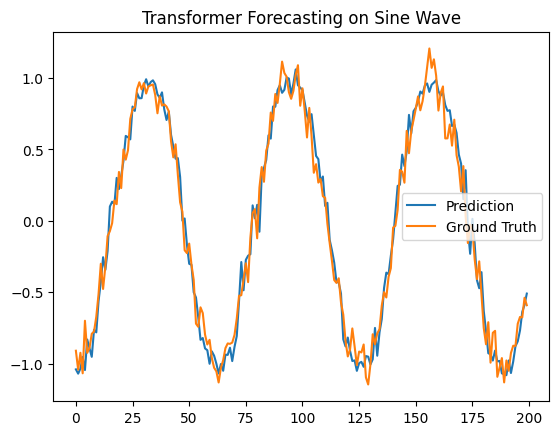

In [1]:
# ## 7. Time Series Forecasting with Transformers

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic sine wave data
t = np.linspace(0, 100, 1000)
y = np.sin(t) + 0.1 * np.random.randn(1000)

# Build dataset: previous `window_size` points → predict next point
window_size = 30
X_seq, Y_seq = [], []
for i in range(len(y) - window_size):
    X_seq.append(y[i:i+window_size])
    Y_seq.append(y[i+window_size])

X_seq = torch.tensor(X_seq, dtype=torch.float32).unsqueeze(-1)  # shape (N, window, 1)
Y_seq = torch.tensor(Y_seq, dtype=torch.float32).unsqueeze(-1)  # shape (N, 1)

# Define a tiny transformer encoder for forecasting
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_model=16, nhead=2, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        return self.head(x[:, -1])

model = TimeSeriesTransformer()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop
for step in range(500):
    i = torch.randint(0, X_seq.size(0), (32,))
    x_batch, y_batch = X_seq[i], Y_seq[i]
    pred = model(x_batch)
    loss = loss_fn(pred, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 100 == 0:
        print(f"Step {step}, loss: {loss.item():.4f}")

# Evaluate on the last part of the sequence
with torch.no_grad():
    preds = model(X_seq[-200:]).squeeze().numpy()
    truth = Y_seq[-200:].squeeze().numpy()

plt.plot(preds, label="Prediction")
plt.plot(truth, label="Ground Truth")
plt.title("Transformer Forecasting on Sine Wave")
plt.legend()
plt.show()